<a href="https://colab.research.google.com/github/endangrusiana123/SLO/blob/main/TugasBesar/BestAccTest_KNN_Optimizer100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tugas Besar SLO
Updated: 16 June 2024
<center>

**Kelompok 7**

**"Diagnosis of Cassava Leaf Diseases"**

| No.| Nama | NIM |
|:-----:|:-----:|:-----:|
| 1.  |Endang Rusiana| 201012320036 |
| 2. |Rachelina Putri Arta S|201012320020|
| 3. |Iqbal Kurniawan Perdana|201012320002|
| 4. |Rizky Araffathia|201012320003|

</center>

#load dataset

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


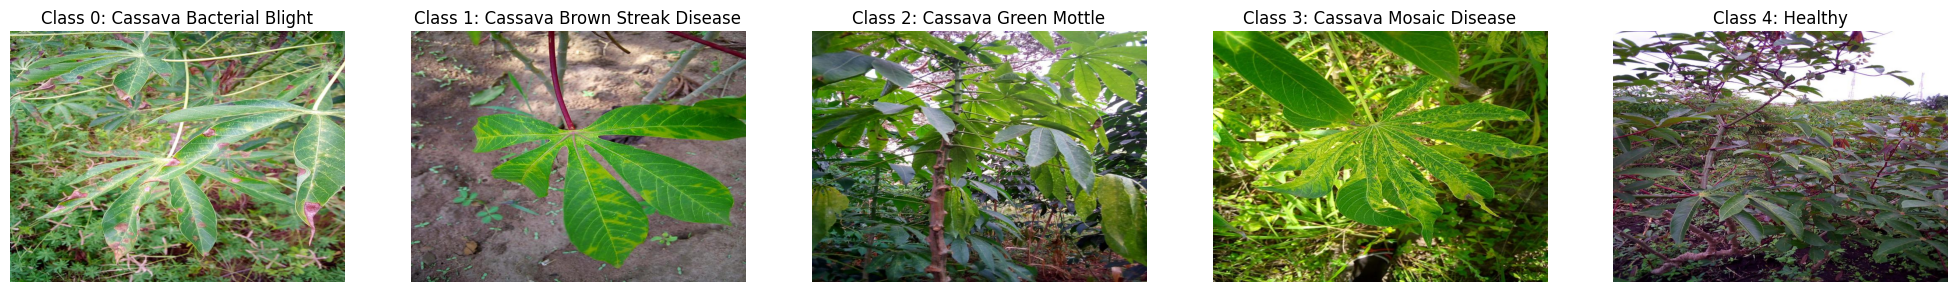

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the dataset directory
dataset_dir = '/content/drive/MyDrive/Colab Notebooks/SLO/Tugas_Besar/Submit/used_dataset100/train'

# Define the class labels
class_labels = [
    'Cassava Bacterial Blight',
    'Cassava Brown Streak Disease',
    'Cassava Green Mottle',
    'Cassava Mosaic Disease',
    'Healthy'
]

# Prepare to collect one sample image from each class
sample_images = []
sample_labels = []
sample_class_numbers = []

# Loop through each class directory and collect one image
for class_index, class_label in enumerate(class_labels):
    class_dir = os.path.join(dataset_dir, str(class_index))
    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
            if filename.endswith(('jpg', 'jpeg', 'png')):
                image_path = os.path.join(class_dir, filename)
                sample_images.append(image_path)
                sample_labels.append(class_label)
                sample_class_numbers.append(class_index)
                break  # Take only one image per class

# Display the sample images
fig, axes = plt.subplots(1, 5, figsize=(25, 10))
for ax, image_path, label, class_number in zip(axes, sample_images, sample_labels, sample_class_numbers):
    img = Image.open(image_path)
    ax.imshow(img)
    ax.set_title(f'Class {class_number}: {label}')
    ax.axis('off')

plt.show()


#import library

In [3]:
from skimage.feature import hog
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import image as mping
import os
import glob
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#image featuring technique

image:  (600, 800, 3)


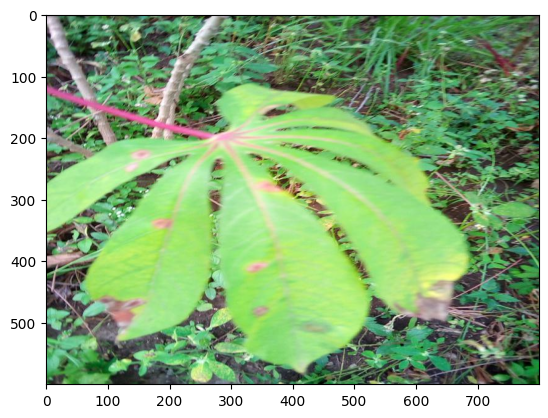

In [4]:
img = np.array(mping.imread('/content/drive/MyDrive/Colab Notebooks/SLO/Tugas_Besar/Submit/used_dataset100/train/0/109816879.jpg'))
img.setflags(write=2)
print('image: ', img.shape)
plt.imshow(img)
plt.show()

#resize image

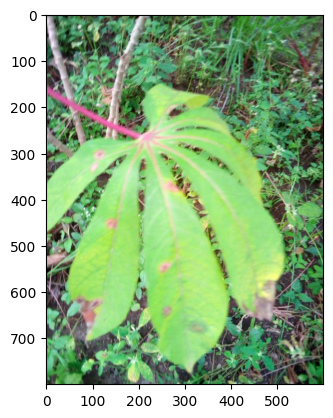

(800, 600, 3)


In [5]:
im_resize_w = 600
im_resize_h = 800

resized_img = cv2.resize(img, (im_resize_w, im_resize_h))
plt.imshow(resized_img)
plt.show()
print(resized_img.shape)

#HOG features

(579474,)
[0.11076216 0.10616167 0.         ... 0.01388857 0.08027147 0.24758062]
(800, 600)


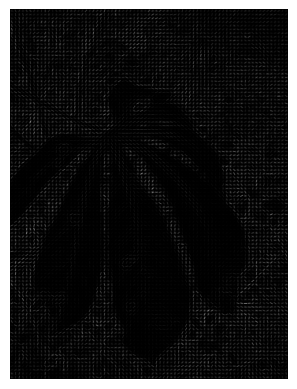

In [6]:
from skimage.feature import hog
import matplotlib.pyplot as plt

# Compute HOG features and visualization
fd, hog_image = hog(resized_img, visualize=True, channel_axis=-1)

# Print the feature descriptor and its shape
print(fd.shape)
print(fd)

# Print the shape of the HOG image
print(hog_image.shape)

# Plot the HOG image
plt.axis("off")
plt.imshow(hog_image, cmap="gray")
plt.show()


#add augmentation

In [7]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg

datagen = ImageDataGenerator(
    #rescale = 1./255,
    zoom_range = [0.5,1],
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
)

In [8]:
def augment_and_extract_hog(image_path, datagen, target_size=(im_resize_w, im_resize_h), augmentations=1):
    img = mpimg.imread(image_path)
    img = np.array(img, dtype=np.float32)

    # Resize the image to the target size
    resized_img = cv2.resize(img, target_size)

    # Prepare an empty list to hold the augmented images' HOG features
    augmented_hog_features = []

    # Expand dimensions to create a batch of 1 image
    img_batch = np.expand_dims(resized_img, axis=0)

    # Generate augmented images
    for _ in range(augmentations):
        for augmented_img in datagen.flow(img_batch, batch_size=1):
            # Convert augmented image back to array and resize if necessary
            augmented_img = augmented_img[0]

            # Extract HOG features from the augmented image
            fd = hog(augmented_img, channel_axis=-1)

            # Append HOG features to the list
            augmented_hog_features.append(fd)

            # Break after getting the required number of augmentations
            if len(augmented_hog_features) >= augmentations:
                break

    return augmented_hog_features


#train dataset

In [9]:
# Augment and extract HOG features for dogs
data_im0 = []
for entry in glob.glob('/content/drive/MyDrive/Colab Notebooks/SLO/Tugas_Besar/Submit/used_dataset100/train/0/*.jpg'):
    augmented_hog_features = augment_and_extract_hog(entry, datagen)
    data_im0.extend(augmented_hog_features)

# Augment and extract HOG features for cats
data_im1 = []
for entry in glob.glob('/content/drive/MyDrive/Colab Notebooks/SLO/Tugas_Besar/Submit/used_dataset100/train/1/*.jpg'):
    augmented_hog_features = augment_and_extract_hog(entry, datagen)
    data_im1.extend(augmented_hog_features)

# Augment and extract HOG features for dogs
data_im2 = []
for entry in glob.glob('/content/drive/MyDrive/Colab Notebooks/SLO/Tugas_Besar/Submit/used_dataset100/train/2/*.jpg'):
    augmented_hog_features = augment_and_extract_hog(entry, datagen)
    data_im2.extend(augmented_hog_features)

# Augment and extract HOG features for cats
data_im3 = []
for entry in glob.glob('/content/drive/MyDrive/Colab Notebooks/SLO/Tugas_Besar/Submit/used_dataset100/train/3/*.jpg'):
    augmented_hog_features = augment_and_extract_hog(entry, datagen)
    data_im3.extend(augmented_hog_features)

# Augment and extract HOG features for cats
data_im4 = []
for entry in glob.glob('/content/drive/MyDrive/Colab Notebooks/SLO/Tugas_Besar/Submit/used_dataset100/train/4/*.jpg'):
    augmented_hog_features = augment_and_extract_hog(entry, datagen)
    data_im4.extend(augmented_hog_features)

# Combine train data
train_data = data_im0 + data_im1 + data_im2 + data_im3 + data_im4
print(len(train_data))

300


#train data labeling

In [10]:
train_lable_list = []

for i in range(len(data_im0)):
  train_lable_list.append('0')
print(train_lable_list)
print(len(train_lable_list))

for i in range(len(data_im1)):
  train_lable_list.append('1')
print(train_lable_list)
print(len(train_lable_list))

for i in range(len(data_im2)):
  train_lable_list.append('2')
print(train_lable_list)
print(len(train_lable_list))

for i in range(len(data_im3)):
  train_lable_list.append('3')
print(train_lable_list)
print(len(train_lable_list))

for i in range(len(data_im4)):
  train_lable_list.append('4')
print(train_lable_list)
print(len(train_lable_list))

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
60
['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1']
120
['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 

#test dataset

In [11]:

test_im0 = []
for entry in glob.glob('/content/drive/MyDrive/Colab Notebooks/SLO/Tugas_Besar/Submit/used_dataset100/test/0/*.jpg'):
  img = np.array(mping.imread(entry))
  resized_img = cv2.resize(img, (im_resize_w, im_resize_h))
  fd = hog(resized_img, channel_axis=-1)
  test_dict = {'data':fd, 'lable':'0'}
  test_im0.append(test_dict)

test_im1 = []
for entry in glob.glob('/content/drive/MyDrive/Colab Notebooks/SLO/Tugas_Besar/Submit/used_dataset100/test/1/*.jpg'):
  img = np.array(mping.imread(entry))
  resized_img = cv2.resize(img, (im_resize_w, im_resize_h))
  fd = hog(resized_img, channel_axis=-1)
  test_dict = {'data':fd, 'lable':'1'}
  test_im1.append(test_dict)

test_im2 = []
for entry in glob.glob('/content/drive/MyDrive/Colab Notebooks/SLO/Tugas_Besar/Submit/used_dataset100/test/2/*.jpg'):
  img = np.array(mping.imread(entry))
  resized_img = cv2.resize(img, (im_resize_w, im_resize_h))
  fd = hog(resized_img, channel_axis=-1)
  test_dict = {'data':fd, 'lable':'2'}
  test_im2.append(test_dict)

test_im3 = []
for entry in glob.glob('/content/drive/MyDrive/Colab Notebooks/SLO/Tugas_Besar/Submit/used_dataset100/test/3/*.jpg'):
  img = np.array(mping.imread(entry))
  resized_img = cv2.resize(img, (im_resize_w, im_resize_h))
  fd = hog(resized_img, channel_axis=-1)
  test_dict = {'data':fd, 'lable':'3'}
  test_im3.append(test_dict)

test_im4 = []
for entry in glob.glob('/content/drive/MyDrive/Colab Notebooks/SLO/Tugas_Besar/Submit/used_dataset100/test/4/*.jpg'):
  img = np.array(mping.imread(entry))
  resized_img = cv2.resize(img, (im_resize_w, im_resize_h))
  fd = hog(resized_img, channel_axis=-1)
  test_dict = {'data':fd, 'lable':'4'}
  test_im4.append(test_dict)


#combine test data
test_data = test_im0 + test_im1 + test_im2 + test_im3 + test_im4
print(len(test_data))

100


#separating data and lables to different list

In [12]:
test_features = []
test_lables = []
for i in test_data:
  test_lables.append(i['lable'])
  test_features.append(i['data'])
print(len(test_features))
print(test_lables)

100
['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4']


#KNN implementation

distance Euclidean

In [13]:
x_axis_k_points = []

f1_euclidean = []
accuracies_euclidean = []
conf_matrix_euclidean = []

ks = [1,5,10]
for k in ks:
  #KNN train data
  knn_euclidean = KNeighborsClassifier(n_neighbors=k)
  knn_euclidean.fit(train_data, train_lable_list)

  #KNN prediction
  pred_lables_euclidean = knn_euclidean.predict(test_features)

  #accuracy of prediction
  acc_euclidean = knn_euclidean.score(test_features, test_lables)
  accuracies_euclidean.append(acc_euclidean)

  #confusion matrix of prediction
  conf_matrix_euclidean.append(metrics.confusion_matrix(test_lables, pred_lables_euclidean))

  #f1 score of prediction
  f1_euclidean.append(metrics.f1_score(test_lables, pred_lables_euclidean, average='weighted'))

  x_axis_k_points.append(k)

Distance Manhattan

In [14]:
f1_manhattan = []
accuracies_manhattan = []
conf_matrix_manhattan = []

for k in ks:
  #KNN train data
  knn_manhattan = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
  knn_manhattan.fit(train_data, train_lable_list)

  #KNN prediction
  pred_lables_manhattan = knn_manhattan.predict(test_features)

  #accuracy of prediction
  acc_manhattan = knn_manhattan.score(test_features, test_lables)
  accuracies_manhattan.append(acc_manhattan)

  #confusion matrix of prediction
  conf_matrix_manhattan.append(metrics.confusion_matrix(test_lables, pred_lables_manhattan))

  #f1 score of prediction
  f1_manhattan.append(metrics.f1_score(test_lables, pred_lables_manhattan, average='weighted'))

distance minkowski

In [15]:
f1_minkowski = []
accuracies_minkowski = []
conf_matrix_minkowski = []

for k in ks:
  #KNN train data
  knn_minkowski = KNeighborsClassifier(n_neighbors=k, metric='minkowski')
  knn_minkowski.fit(train_data, train_lable_list)

  #KNN prediction
  pred_lables_minkowski = knn_minkowski.predict(test_features)

  #accuracy of prediction
  acc_minkowski = knn_minkowski.score(test_features, test_lables)
  accuracies_minkowski.append(acc_minkowski)

  #confusion matrix of prediction
  conf_matrix_minkowski.append(metrics.confusion_matrix(test_lables, pred_lables_minkowski))

  #f1 score of prediction
  f1_minkowski.append(metrics.f1_score(test_lables, pred_lables_minkowski, average='weighted'))

#scores

scores euclidean

FOR k= 1 , f1 score:  0.1724436090225564 , accuracy:  0.24 , 
confusion matrix:
 [[ 0  8  2 10  0]
 [ 1  9  3  7  0]
 [ 0  9  3  8  0]
 [ 0  2  5 12  1]
 [ 2  9  2  7  0]]
Test Image: 100


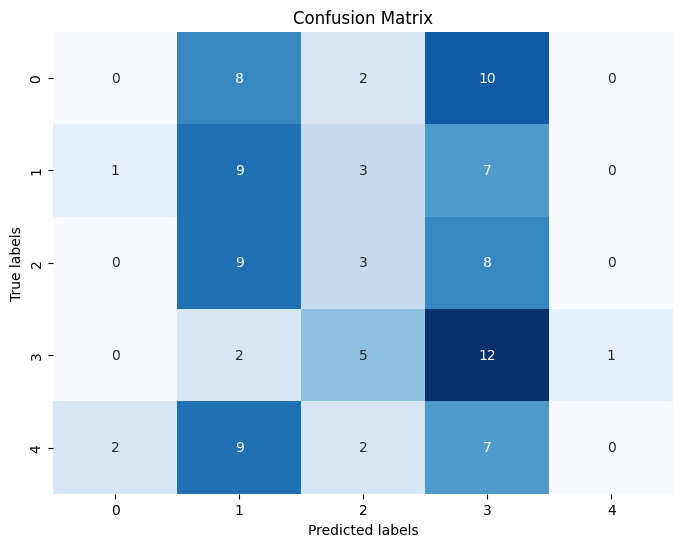

Accuracy: 0.24
Sensitivity: 0.9
Specificity: 0.0
F1 Score: 0.1724436090225564


FOR k= 2 , f1 score:  0.1788888888888889 , accuracy:  0.25 , 
confusion matrix:
 [[ 0 18  1  1  0]
 [ 0 14  3  3  0]
 [ 0 17  2  1  0]
 [ 0  9  2  9  0]
 [ 0 12  2  6  0]]
Test Image: 100


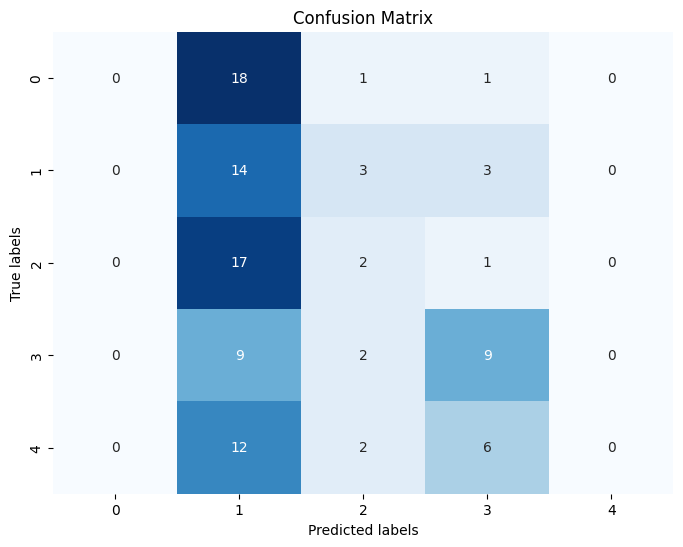

Accuracy: 0.25
Sensitivity: 1.0
Specificity: 0.0
F1 Score: 0.1788888888888889


FOR k= 3 , f1 score:  0.15059268980057225 , accuracy:  0.24 , 
confusion matrix:
 [[ 0 17  0  3  0]
 [ 0 16  1  3  0]
 [ 0 15  1  4  0]
 [ 0 12  1  7  0]
 [ 0 14  0  6  0]]
Test Image: 100


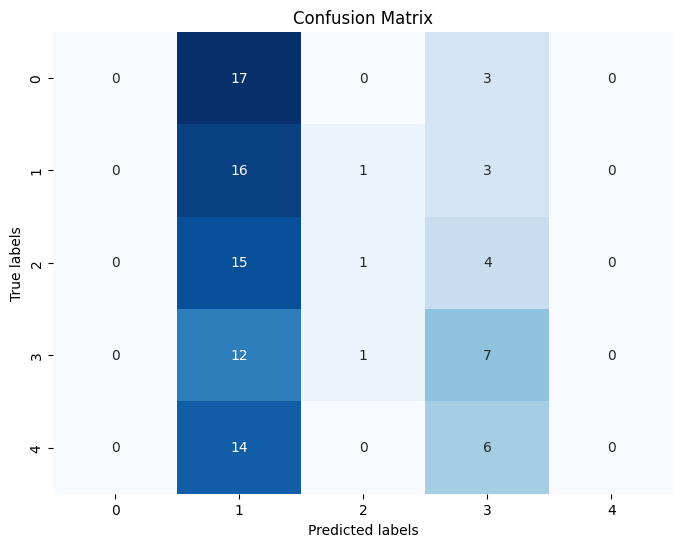

Accuracy: 0.24
Sensitivity: 1.0
Specificity: 0.0
F1 Score: 0.15059268980057225




In [16]:
import seaborn as sns

for i in range(len(f1_euclidean)):
  print('FOR k=', i+1,', f1 score: ', f1_euclidean[i], ', accuracy: ', accuracies_euclidean[i], ', \nconfusion matrix:\n', conf_matrix_euclidean[i])

  # Compute accuracy
  accuracy = accuracies_euclidean[i]

  # Compute confusion matrix
  cm = conf_matrix_euclidean[i]

  # Compute sensitivity and specificity
  true_negatives = cm[0, 0]
  false_negatives = cm[1, 0]
  true_positives = cm[1, 1]
  false_positives = cm[0, 1]

  sensitivity = true_positives / (true_positives + false_negatives)
  specificity = true_negatives / (true_negatives + false_positives)

  # Compute F1 score
  f1 = f1_euclidean[i]

  print("Test Image:",len(test_lables))
  # Plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()

  print("Accuracy:", accuracy)
  print("Sensitivity:", sensitivity)
  print("Specificity:", specificity)
  print("F1 Score:", f1)
  print('\n')

scores manhattan

FOR k= 1 , f1 score:  0.20403195837978447 , accuracy:  0.24 , 
confusion matrix:
 [[ 1 12  2  4  1]
 [ 3 11  1  4  1]
 [ 0 10  4  6  0]
 [ 1  8  3  7  1]
 [ 1 11  2  5  1]]
Test Image: 100


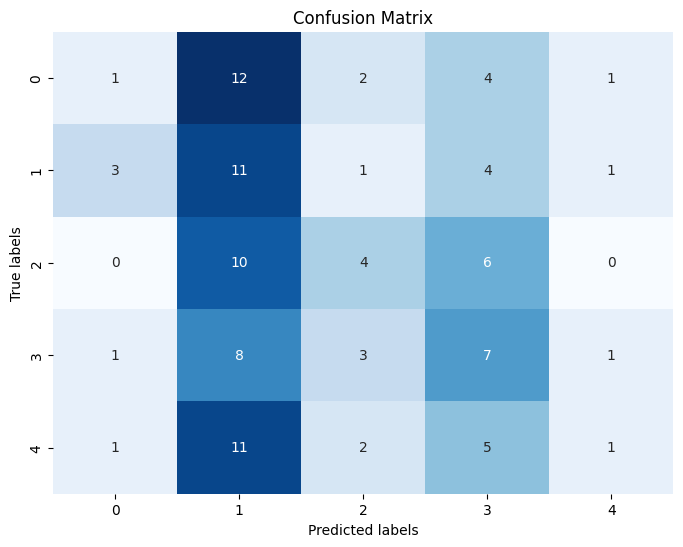

Accuracy: 0.24
Sensitivity: 0.7857142857142857
Specificity: 0.07692307692307693
F1 Score: 0.20403195837978447


FOR k= 2 , f1 score:  0.17294372294372296 , accuracy:  0.21 , 
confusion matrix:
 [[ 4 13  2  1  0]
 [ 5  9  0  6  0]
 [ 1 15  0  3  1]
 [ 0  8  3  8  1]
 [ 2 12  2  4  0]]
Test Image: 100


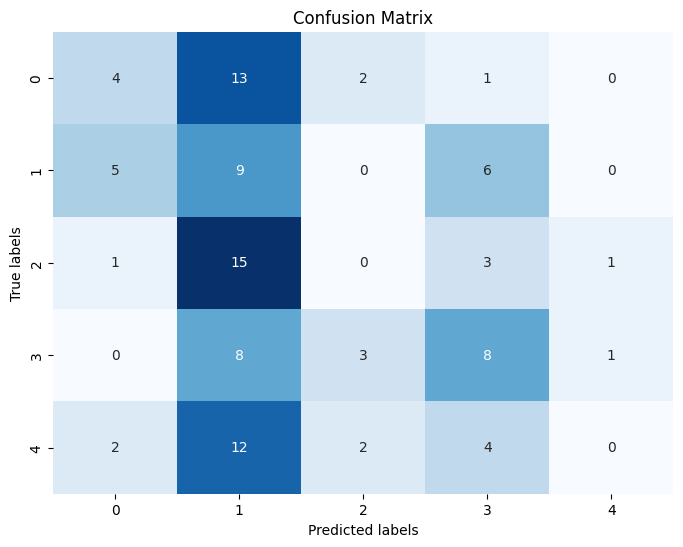

Accuracy: 0.21
Sensitivity: 0.6428571428571429
Specificity: 0.23529411764705882
F1 Score: 0.17294372294372296


FOR k= 3 , f1 score:  0.23035539498954133 , accuracy:  0.25 , 
confusion matrix:
 [[ 4 13  1  1  1]
 [ 2 10  2  4  2]
 [ 2 11  3  4  0]
 [ 2 10  1  7  0]
 [ 3 10  1  5  1]]
Test Image: 100


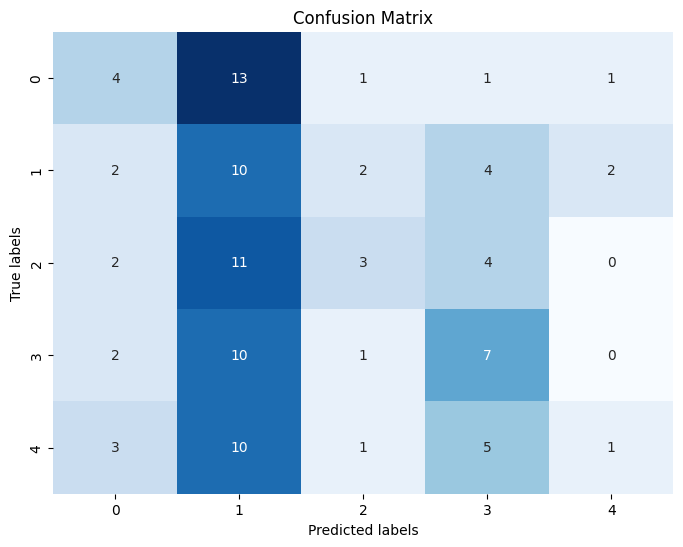

Accuracy: 0.25
Sensitivity: 0.8333333333333334
Specificity: 0.23529411764705882
F1 Score: 0.23035539498954133




In [17]:
import seaborn as sns

for i in range(len(f1_manhattan)):
  print('FOR k=', i+1,', f1 score: ', f1_manhattan[i], ', accuracy: ', accuracies_manhattan[i], ', \nconfusion matrix:\n', conf_matrix_manhattan[i])

  # Compute accuracy
  accuracy = accuracies_manhattan[i]

  # Compute confusion matrix
  cm = conf_matrix_manhattan[i]

  # Compute sensitivity and specificity
  true_negatives = cm[0, 0]
  false_negatives = cm[1, 0]
  true_positives = cm[1, 1]
  false_positives = cm[0, 1]

  sensitivity = true_positives / (true_positives + false_negatives)
  specificity = true_negatives / (true_negatives + false_positives)

  # Compute F1 score
  f1 = f1_manhattan[i]

  print("Test Image:",len(test_lables))
  # Plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()

  print("Accuracy:", accuracy)
  print("Sensitivity:", sensitivity)
  print("Specificity:", specificity)
  print("F1 Score:", f1)
  print('\n')

scores minkowski

FOR k= 1 , f1 score:  0.1724436090225564 , accuracy:  0.24 , 
confusion matrix:
 [[ 0  8  2 10  0]
 [ 1  9  3  7  0]
 [ 0  9  3  8  0]
 [ 0  2  5 12  1]
 [ 2  9  2  7  0]]
Test Image: 100


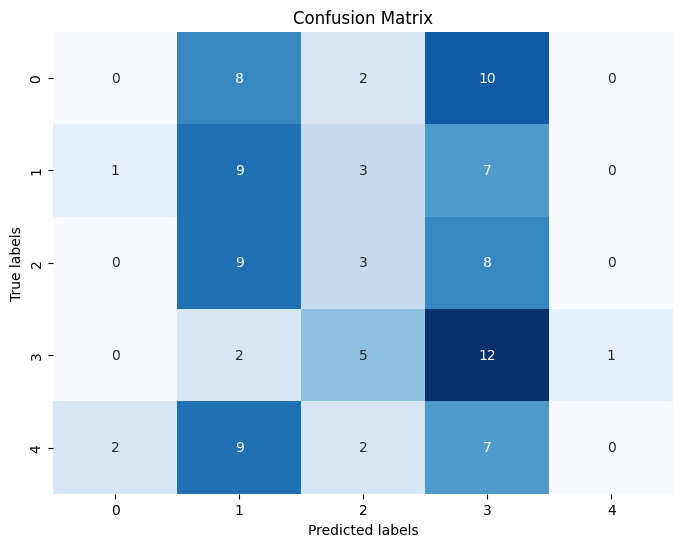

Accuracy: 0.24
Sensitivity: 0.9
Specificity: 0.0
F1 Score: 0.1724436090225564


FOR k= 2 , f1 score:  0.1788888888888889 , accuracy:  0.25 , 
confusion matrix:
 [[ 0 18  1  1  0]
 [ 0 14  3  3  0]
 [ 0 17  2  1  0]
 [ 0  9  2  9  0]
 [ 0 12  2  6  0]]
Test Image: 100


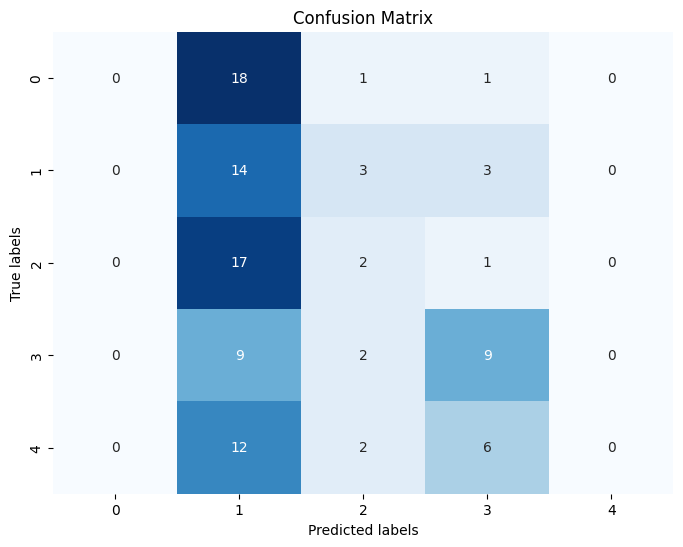

Accuracy: 0.25
Sensitivity: 1.0
Specificity: 0.0
F1 Score: 0.1788888888888889


FOR k= 3 , f1 score:  0.15059268980057225 , accuracy:  0.24 , 
confusion matrix:
 [[ 0 17  0  3  0]
 [ 0 16  1  3  0]
 [ 0 15  1  4  0]
 [ 0 12  1  7  0]
 [ 0 14  0  6  0]]
Test Image: 100


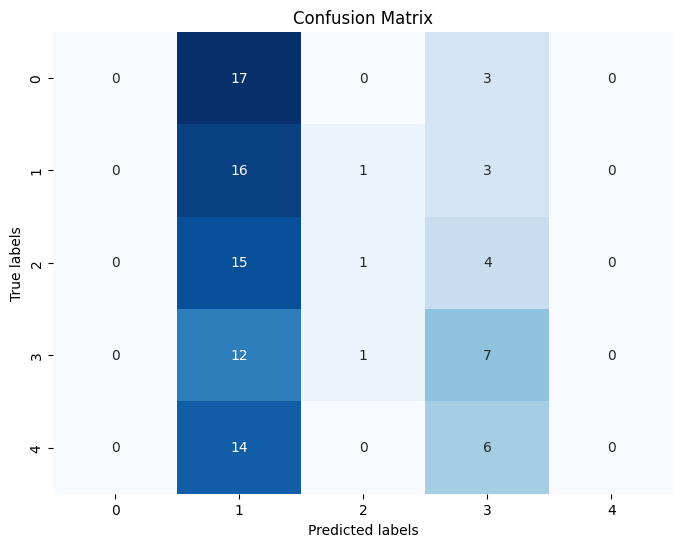

Accuracy: 0.24
Sensitivity: 1.0
Specificity: 0.0
F1 Score: 0.15059268980057225




In [18]:
import seaborn as sns

for i in range(len(f1_minkowski)):
  print('FOR k=', i+1,', f1 score: ', f1_minkowski[i], ', accuracy: ', accuracies_minkowski[i], ', \nconfusion matrix:\n', conf_matrix_minkowski[i])

  # Compute accuracy
  accuracy = accuracies_minkowski[i]

  # Compute confusion matrix
  cm = conf_matrix_minkowski[i]

  # Compute sensitivity and specificity
  true_negatives = cm[0, 0]
  false_negatives = cm[1, 0]
  true_positives = cm[1, 1]
  false_positives = cm[0, 1]

  sensitivity = true_positives / (true_positives + false_negatives)
  specificity = true_negatives / (true_negatives + false_positives)

  # Compute F1 score
  f1 = f1_minkowski[i]

  print("Test Image:",len(test_lables))
  # Plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()

  print("Accuracy:", accuracy)
  print("Sensitivity:", sensitivity)
  print("Specificity:", specificity)
  print("F1 Score:", f1)
  print('\n')

#plotting scores

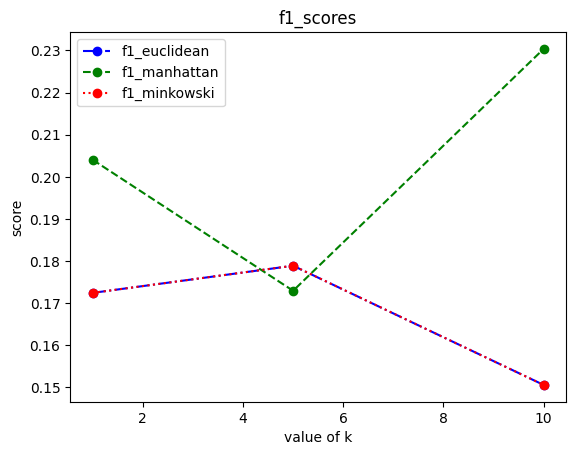

In [19]:
plt.plot(x_axis_k_points, f1_euclidean, label='f1_euclidean', linestyle='-.', color='blue', marker='o')
plt.plot(x_axis_k_points, f1_manhattan, label='f1_manhattan', linestyle='--', color='green', marker='o')
plt.plot(x_axis_k_points, f1_minkowski, label='f1_minkowski', linestyle=':', color='red', marker='o')
plt.title('f1_scores')
plt.xlabel('value of k')
plt.ylabel('score')
plt.legend()
plt.show()

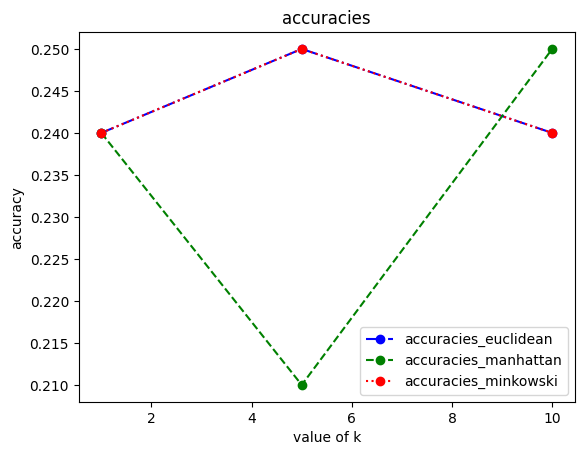

In [20]:
plt.plot(x_axis_k_points, accuracies_euclidean, label='accuracies_euclidean', linestyle='-.', color='blue', marker='o')
plt.plot(x_axis_k_points, accuracies_manhattan, label='accuracies_manhattan',linestyle='--', color='green', marker='o')
plt.plot(x_axis_k_points, accuracies_minkowski, label='accuracies_minkowski',linestyle=':', color='red', marker='o')
plt.title('accuracies')
plt.xlabel('value of k')
plt.ylabel('accuracy')
plt.legend()
plt.show()